## **Caltech 101 dataset: From-Scratch_VGG + ResNet**
<author> &copy; Prepared by Oscar Mendoza Cerna

It combines a VGG model created from scratch with the ResNet50 pre-trained model. This hybrid approach aims to leverage the strengths of both models to enhance classification accuracy. The VGG model is designed and trained from scratch, while the ResNet50 model, pre-trained on a large dataset, is fine-tuned for the Caltech-101 dataset. The features extracted from both models are then combined to make predictions.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt     # for plotting
import numpy as np                  # for reshaping, array manipulation
import pandas as pd
import cv2                          # for image loading and colour conversion
import tensorflow as tf             # for bulk image resize
import os
import glob
import random
import time
import seaborn as sns
from matplotlib import gridspec
import IPython
from IPython.display import SVG

from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV

import keras
from keras.layers import Dense, Dropout
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

from keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
#import tensorflow_datasets as tfds

from sklearn.svm import SVC
from time import process_time

from tensorflow.keras.layers import Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16, ResNet50
from sklearn.utils import class_weight

## Useful Functions

# allow you to stop model training after a set period of time    
class TrainForTime(keras.callbacks.Callback):
    def __init__(self, train_time_mins=5,):
        super().__init__()

        self.train_time_mins = train_time_mins
        self.epochs = 0
        self.train_time = 0
        self.end_early = False

    def on_train_begin(self, logs=None):
        # save the start time
        self.start_time = tf.timestamp()

    def on_epoch_end(self, epoch, logs=None):
        self.epochs += 1
        current_time = tf.timestamp()
        training_time = (current_time - self.start_time)
        if (training_time / 60) > self.train_time_mins:
            self.train_time = current_time - self.start_time
            self.model.stop_training = True
            self.end_early = True

    def on_train_end(self, logs=None):
        if self.end_early:
            print('training time exceeded and ending early')
            print(f'training ended on epoch {self.epochs}')
            print(f'training time = {self.train_time / 60} mins')
            
           
random.seed(4)


# Plot some images and their labels. Will plot the first 200 samples in a 20x20 grid
##  x: array of images, of shape (samples, width, height, channels)
##  y: labels of the images

def plot_images(x, y):
    fig = plt.figure(figsize=[15, 18])
    for i in range(100):
        ax = fig.add_subplot(10, 10, i + 1)
        ax.imshow(x[i,:])
        ax.set_title(y[i])
                     
#pip install tensorflow==2.8.3
# Version                     
print(keras.__version__)
print(tf.__version__)
print(np.__version__)
#print(sklearn.__version__)
#2.11.0
#2.11.0
#1.23.5

# Evaluation of Model
def plot_training(history):
    fig = plt.figure(figsize=[20, 5])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss vs Validation Loss')
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'], label="Train Accuracy")
    ax.plot(history.history['val_accuracy'], label="Val Accuracy")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training Accuracy vs Validation Accuracy')
    ax.legend()
    
    plt.show()


def eval_model(model, X_train, y_train, X_test, y_test, dcnn_train_time):

    test_scores = model.evaluate(X_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])
    print("")

    fig = plt.figure(figsize=[20, 8])

    ax = fig.add_subplot(1, 2, 1)

    dcnn_inference_start = process_time()
    # predict on the training set
    pred = model.predict(X_train, verbose=False)
    dcnn_inference_end = process_time()
    # get indexes for the predictions and ground truth, this is converting back from a one-hot representation
    # to a single index
    indexes = np.argmax(pred, axis=1)

    # convert to numpy arrays
    y_train = np.argmax(y_train, axis=1)
    indexes = np.array(indexes)

    # compute the confusion matrix
    confusion_mtx = confusion_matrix(y_train, indexes)
    sns.heatmap(confusion_mtx, xticklabels=range(num_classes), yticklabels=range(num_classes),
                annot=True, fmt='g', ax=ax)
    # set the title to the F1 scope
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Training, F1 Score: %f' % f1_score(y_train, indexes, average='weighted'))
    print(classification_report(y_train, indexes))

    # repeat visualization for the test set
    ax = fig.add_subplot(1, 2, 2)
    dcnn_pred_start = process_time()
    pred = model.predict(X_test, verbose=False)
    dcnn_pred_end = process_time()
    indexes = np.argmax(pred, axis=1)

    # convert to numpy arrays
    y_test = np.argmax(y_test, axis=1)
    indexes = np.array(indexes)

    # compute the confusion matrix
    confusion_mtx = confusion_matrix(y_test, indexes)
    sns.heatmap(confusion_mtx, xticklabels=range(num_classes), yticklabels=range(num_classes),
                annot=True, fmt='g', ax=ax)

    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Testing, F1 Score: %f' % f1_score(y_test, indexes, average='weighted'))

    dcnn_train_time = dcnn_train_time
    dcnn_inference_train_time = dcnn_inference_end - dcnn_inference_start
    dcnn_inference_test_time = dcnn_pred_end - dcnn_pred_start

    print('Training Time: %f\nInference Time (training set): %f\nInference Time (testing set): %f' % \
          (dcnn_train_time, dcnn_inference_train_time, dcnn_inference_test_time))
    print("")

    print(classification_report(y_test, indexes))


def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

2.11.0
2.11.0
1.23.5


## Data

### Data Preprocessing
- The Caltech-101 dataset is a comprehensive collection of images that exhibits a wide range of diversity. It comprises of 9,144 images distributed across 101 classes, each representing a distinct object. These classes include various objects such as cameras, soccer balls, or lamps. Additionally, an extra class named "BACKGROUND Google" is specifically designed to encompass a diverse set of images featuring textures, landscapes, and indoor scenes (‘Caltech 101’, 2023).

- The distribution of images across the classes is not uniform, with each class containing between 40 and 800 images. This variability in image counts allows for a more realistic representation of real-world scenarios and provides a suitable foundation for classification tasks (‘Caltech 101’, 2023).

- The images in the dataset were loaded with a specific size of 64 x 64 pixels, preserving the RGB format with three channels, considering certain computational constraints such as GPU memory and RAM. Although this smaller size may impose limitations on image quality, it allowed us to achieve efficient processing and analysis.

- To enhance the classification task in DCNN, the data augmentation technique of flipping the images horizontally was applied. This augmentation modifies the original images by creating additional samples with different orientations.

### Method From-scratch VGG and ResNet50
- The approach selected was the combination of VGG and ResNet50 models. Firstly, a VGG model was designed from scratch, consisting of 4 convolutional blocks with 16, 32, 64 and 128 filters, respectively and followed by a spatial dropout of 0.2 and max pooling. Then, it was flattened the output of the last convolutional block and a batch normalization, and dropout of 0.2 is applied after two fully connected dense layers with 512 and 256 units and ReLU activation to smooth the data and prevent overfitting. Finally, the output of the last layer is connected to another dense layer with 512 units, ReLU activation, L2 regularization with a factor of 0.01, and dropout of 0.5 also to prevent overfitting.

- Secondly, the pre-trained ResNet50 model was added to the from-scratch VGG model. The parameters of the ResNet50 network were set to non-trainable to leverage its pre-trained features. The outputs of the ResNet50 network were flattened to 1D and connected to a dense layer with 512 units, ReLU activation, and dropout of 0.5. Finally, the features from both the from-scratch VGG model and the ResNet50 model were concatenated and passed through a fully connected layer with 102 units to represent the 102 classes in the dataset. The activation function used was softmax, which outputs the probabilities of the input image belonging to each class.

- The model was then compiled with an Adam optimizer using a learning rate of 1e-4 and the CategoricalCrossentropy loss function, suitable for multi-class classification tasks. During training, the model was fitted using a batch size of 256 and 35epochs. It's worth noting that the model received two copies of the X_train data due to the use of two architectures (from-scratch VGG and ResNet50) in the network, but the final output is a single classification per each class.

In [ ]:
# Predefined
image_shape = (64, 64)
input_shape = (64, 64, 3)  # image size loaded
seed = 52  # for reproducibility

data = keras.utils.image_dataset_from_directory(
    "caltech-101",
    labels="inferred",
    color_mode="rgb",
    batch_size=16,  # None  # Set a smaller batch size
    shuffle=True,
    seed=seed,
    image_size=image_shape,
    crop_to_aspect_ratio=True)

# Iterate over all batches to load all the images and labels
images = []
labels = []
for batch_images, batch_labels in data:
    images.append(batch_images)
    labels.append(batch_labels)

images = np.concatenate(images, axis=0)
labels = np.concatenate(labels, axis=0)

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

class_names = data.class_names
num_classes = len(np.unique(labels))
print("Number of classes:", num_classes)

# Split the data
X_train, X_test_val, y_train, y_test_val = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42, stratify=y_test_val)

# Convert zero-indexed labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Verify the shapes of the split data
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

# Perform data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  #layers.RandomZoom(-0.00025),
  #layers.RandomContrast(0.5)
])

# Design Model
inputs = Input(shape=(64, 64, 3), name='img')
augmented = data_augmentation(inputs)

# Custom VGG architecture
vgg_model = vgg_net(augmented, [16, 32, 64, 128], [512, 256], 0.2, 0.2)

# Load the pre-trained models
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers in the base models   
for layer in resnet_model.layers:
    layer.trainable = False

# Build the model architecture
vgg_output = Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(vgg_model)
vgg_output = Dropout(0.5)(vgg_output)

resnet_output = resnet_model.output

Found 9144 files belonging to 102 classes.
Images shape: (9144, 64, 64, 3)
Labels shape: (9144,)
Number of classes: 102
X_train shape: (6400, 64, 64, 3)
X_val shape: (1372, 64, 64, 3)
X_test shape: (1372, 64, 64, 3)
y_train shape: (6400, 102)
y_val shape: (1372, 102)
y_test shape: (1372, 102)


In [4]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [2]:
resnet_output = Flatten()(resnet_output)
resnet_output = Dense(512, activation='relu')(resnet_output)
resnet_output = Dropout(0.5)(resnet_output)

# Combine the outputs of both models
concatenated_features = concatenate([vgg_output, resnet_output])

# Define classification task with number of classes
classification = Dense(num_classes, activation='softmax')(concatenated_features)

# Create the model
model = Model(inputs=[inputs, resnet_model.input], outputs=classification)

model.compile(optimizer=Adam(), loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
             metrics=['accuracy'])

# Batch size and epochs
batch_size = 256
epochs_size = 35

# Train the model
dcnn_train_start = process_time()
history = model.fit([X_train, X_train], y_train, epochs=epochs_size, batch_size=batch_size, 
                    validation_data=([X_val, X_val], y_val),verbose=True)
dcnn_train_end = process_time()

# Obtain predicted labels from the model's predictions (train)
dcnn_inference_start = process_time()
train_predictions = model.predict([X_train, X_train])
dcnn_inference_end = process_time()
 
# Obtain predicted labels from the model's predictions (test)
dcnn_pred_start = process_time()
test_predictions = model.predict([X_test, X_test])
dcnn_pred_end = process_time()

# Convert predicted labels to class labels
train_labels_pred = np.argmax(train_predictions, axis=1)
test_labels_pred = np.argmax(test_predictions, axis=1)

# Convert target labels to 1D arrays
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, train_labels_pred)
test_accuracy = accuracy_score(y_test, test_labels_pred)

# Time: Calculate training, inference, prediction time
dcnn_train_time = dcnn_train_end - dcnn_train_start
dcnn_inference_train_time = dcnn_inference_end - dcnn_inference_start
dcnn_inference_test_time = dcnn_pred_end - dcnn_pred_start

print("Train Accuracy: %f\nTest Accuracy: %f\nTraining Time: %f\nInference Time (training set): %f\nInference Time (testing set): %f" % \
      (train_accuracy, test_accuracy, dcnn_train_time, dcnn_inference_train_time, dcnn_inference_test_time))

Found 9144 files belonging to 102 classes.
Images shape: (9144, 64, 64, 3)
Labels shape: (9144,)
Number of classes: 102
X_train shape: (6400, 64, 64, 3)
X_val shape: (1372, 64, 64, 3)
X_test shape: (1372, 64, 64, 3)
y_train shape: (6400, 102)
y_val shape: (1372, 102)
y_test shape: (1372, 102)
Epoch 1/35


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


25/25 [==============================] - 20s 232ms/step - loss: 6.2605 - accuracy: 0.3744 - val_loss: 5.1395 - val_accuracy: 0.4060
Epoch 2/35
25/25 [==============================] - 4s 163ms/step - loss: 3.4603 - accuracy: 0.5880 - val_loss: 2.9967 - val_accuracy: 0.6013
Epoch 3/35
25/25 [==============================] - 4s 164ms/step - loss: 2.1993 - accuracy: 0.6797 - val_loss: 2.0986 - val_accuracy: 0.6429
Epoch 4/35
25/25 [==============================] - 4s 166ms/step - loss: 1.3813 - accuracy: 0.7672 - val_loss: 1.6883 - val_accuracy: 0.6727
Epoch 5/35
25/25 [==============================] - 4s 166ms/step - loss: 0.9268 - accuracy: 0.8180 - val_loss: 1.4499 - val_accuracy: 0.7099
Epoch 6/35
25/25 [==============================] - 4s 167ms/step - loss: 0.6607 - accuracy: 0.8552 - val_loss: 1.3755 - val_accuracy: 0.7143
Epoch 7/35
25/25 [==============================] - 4s 165ms/step - loss: 0.4804 - accuracy: 0.8850 - val_loss: 1.2972 - val_accuracy: 0.7165
Epoch 8/35
25/25

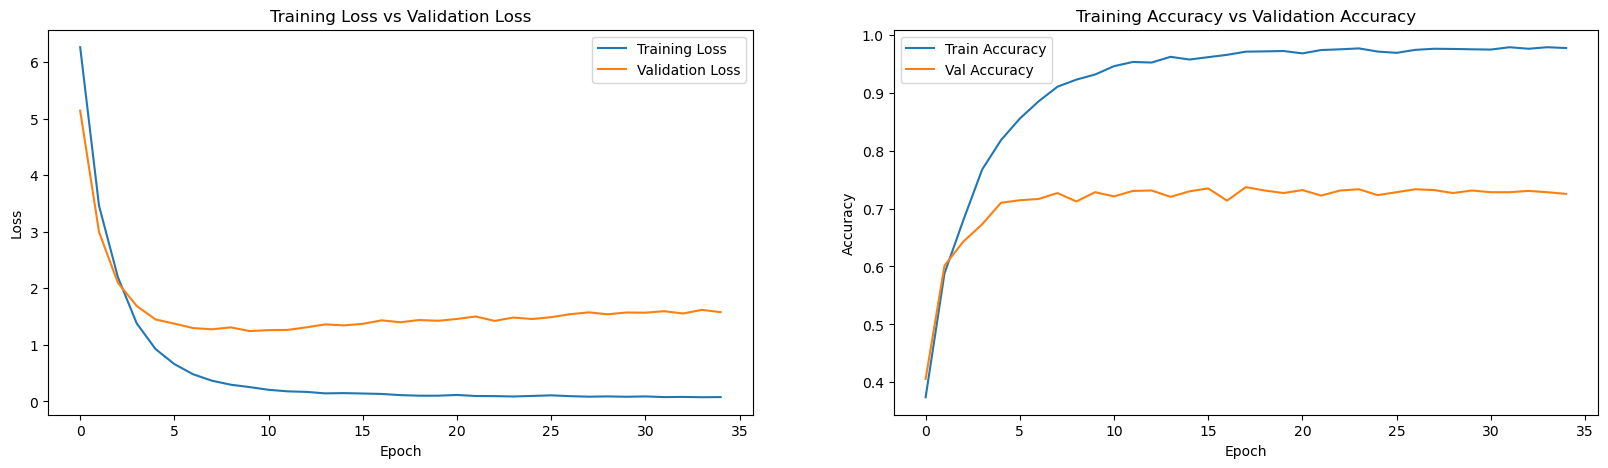

In [3]:
plot_training(history)

In [4]:
from sklearn.metrics import f1_score

# Calculate F1 scores
train_f1_score = f1_score(y_train, train_labels_pred, average='weighted')
test_f1_score = f1_score(y_test, test_labels_pred, average='weighted')

In [5]:
train_f1_score

0.99937554137751

In [6]:
test_f1_score

0.7176337628088406

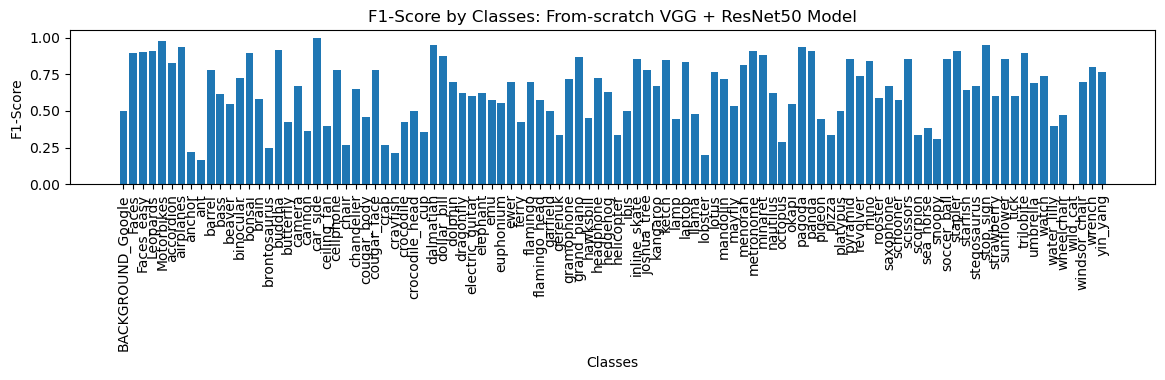

In [19]:
import matplotlib.pyplot as plt

# Get the classification report
report = classification_report(y_test, test_labels_pred, output_dict=True)

# Convert the classification report dictionary to a dataframe
df = pd.DataFrame(report).transpose()

df1 = df[0:102]
df1['classes'] = class_names

# Extract the required columns from the DataFrame
df_ = df1[['f1-score', 'classes']]

# Set x and y variables
x = df_['classes']
y = df_['f1-score']

# Set the figure size
plt.figure(figsize=(14, 2))  # Adjust the values as desired (width, height)

# Create bar plot
plt.bar(x, y)
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.title('F1-Score by Classes: From-scratch VGG + ResNet50 Model')
plt.xticks(rotation=90)
plt.show()


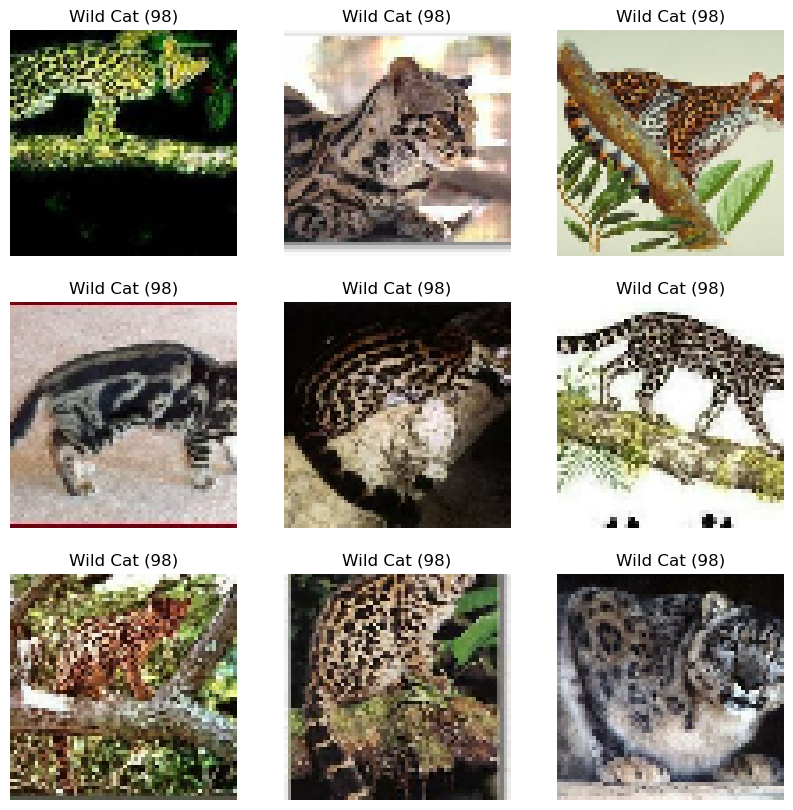

In [22]:
plt.figure(figsize=(10, 10))

wild_cat_images = []
wild_cat_labels = []

# Find images and labels belonging to the 'wild cat' class
for image, label in zip(images, labels):
    if class_names[label] == 'wild_cat':
        wild_cat_images.append(image)
        wild_cat_labels.append(label)

# Display images from the 'wild cat' class
for i in range(min(9, len(wild_cat_images))):
    ax = plt.subplot(3, 3, i + 1)
    image = wild_cat_images[i].astype("uint8")
    plt.imshow(image)
    plt.title(f"Wild Cat ({wild_cat_labels[i]})")  # Add the class number to the title
    plt.axis("off")

plt.show()


### Conclusion
- The accuracy and f1-score were 72% and 71% respectively.  
- It is clear that the imbalance of the data is affecting the classification of the minority of classes. For example, the “wild_cat” could not be classified for the model probably because of the small number of samples (34) and the low quality of the images. 
- The challenging “BACKGROUND_Google” class performed with a 50%, being acceptable performance. 

Therefore, the model obtained an acceptable performance considering the small size of the images (64x64).